In [10]:
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from umap import UMAP

import torch
from torch.nn import Linear, MSELoss, Embedding
import torch.nn.functional as F

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected, AddSelfLoops, NormalizeFeatures

In [11]:
torch.__version__

'1.13.0+cpu'

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Get (preprocessed) data

In [13]:
user_path = './datasets/20221108_movieLens100k_users.csv'
movie_path = './datasets/20221108_movieLens100k_movies.csv'
rating_path = './datasets/20221108_movieLens100k_ratings.csv'

user_df, movie_df, rating_df = pd.read_csv(user_path), pd.read_csv(movie_path), pd.read_csv(rating_path)

user_df.shape, movie_df.shape, rating_df.shape

((671, 1), (9125, 24), (100004, 3))

In [14]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  671 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


In [15]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movieId      9125 non-null   int64  
 1   Action       9125 non-null   int64  
 2   Adventure    9125 non-null   int64  
 3   Animation    9125 non-null   int64  
 4   Children     9125 non-null   int64  
 5   Comedy       9125 non-null   int64  
 6   Crime        9125 non-null   int64  
 7   Documentary  9125 non-null   int64  
 8   Drama        9125 non-null   int64  
 9   Fantasy      9125 non-null   int64  
 10  Film-Noir    9125 non-null   int64  
 11  Horror       9125 non-null   int64  
 12  IMAX         9125 non-null   int64  
 13  Musical      9125 non-null   int64  
 14  Mystery      9125 non-null   int64  
 15  Romance      9125 non-null   int64  
 16  Sci-Fi       9125 non-null   int64  
 17  Thriller     9125 non-null   int64  
 18  War          9125 non-null   int64  
 19  Wester

In [16]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [17]:
assert not user_df.isnull().values.any(), 'Null values in user dataset!'
assert not movie_df.isnull().values.any(), 'Null values in movie dataset!'
assert not rating_df.isnull().values.any(), 'Null values in rating dataset!'

### UMAP - Plot dimension reduction

In [18]:
user_embeddings = np.load('./datasets/20221125_np_user_embeddings.npy')
user_embeddings.shape

(671, 8)

In [19]:
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
user_embed_umap_2d = umap_2d.fit_transform(user_embeddings)
user_embed_umap_2d.shape

(671, 2)

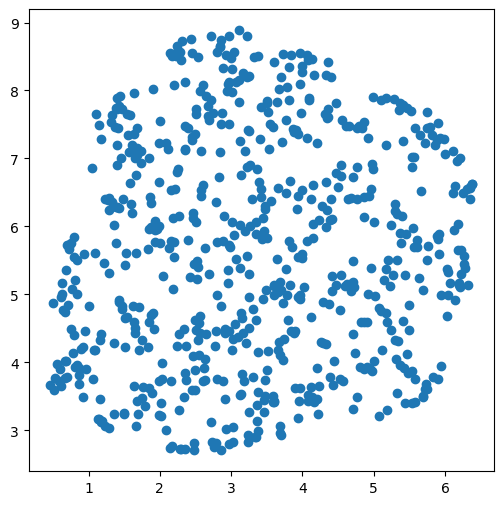

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(x=user_embed_umap_2d[:,0], y=user_embed_umap_2d[:,1])
plt.show()

### Encoding & Scaling data

In [21]:
user_encoder, movie_encoder = LabelEncoder(), LabelEncoder()
scaler = StandardScaler()

In [22]:
user_df['userId'] = user_encoder.fit_transform(user_df['userId'])
movie_df['movieId'] = movie_encoder.fit_transform(movie_df['movieId'])

rating_df['userId'] = user_encoder.transform(rating_df['userId'])
rating_df['movieId'] = movie_encoder.transform(rating_df['movieId'])

In [23]:
features_to_scale = ['imdbRating', 'imdbVotes', 'runtime', 'year']
scaled_features = scaler.fit_transform(movie_df[features_to_scale])
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale)

In [24]:
movie_df.drop(columns=features_to_scale, axis=1, inplace=True)
movie_df = pd.concat([movie_df, scaled_features_df], axis=1)
movie_df.head()

,movieId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,imdbRating,imdbVotes,runtime,year
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,1.528928,5.144229,-0.876122,0.158905
1,1,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0.174897,1.394602,-0.058951,0.158905
2,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,-0.115253,-0.318207,-0.165539,0.158905
3,3,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,-1.082418,-0.426889,0.651632,0.158905
4,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,-0.792268,-0.248423,0.012107,0.158905


In [25]:
# movie_df.describe()

In [26]:
# rating_df

### Create Pytorch Geometric (heterogenious) Dataset

In [27]:
def create_hetero_dataset(user_embed:np.array) -> dict:
    if user_embed is None:
        x_user = torch.eye(len(user_df['userId'].values))
    else:
        x_user = torch.Tensor(user_embed)

    x_movie = movie_df.drop(columns=['movieId'], axis=1)
    x_movie = torch.Tensor(x_movie.values)
    x_movie.size()

    edge_index = torch.Tensor(rating_df[['userId', 'movieId']].values).swapaxes(1,0).to(torch.long)
    edge_index.size(), edge_index

    edge_label = torch.Tensor(rating_df['rating'].values)
    edge_label.size(), edge_label

    data = HeteroData()
    data['user'].x = x_user
    data['movie'].x = x_movie

    data[('user', 'rates', 'movie')].edge_index = edge_index
    data[('user', 'rates', 'movie')].edge_label = edge_label

    data = ToUndirected()(data)
    del data[('movie', 'rev_rates', 'user')].edge_label
    
    data = data.to(device)
    print(data)

    return data

In [28]:
data = create_hetero_dataset(user_embed=None)

HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)


### GNN Model

In [29]:
class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # these convolutions have been replicated to match the number of edge types
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin_out = Linear(hidden_channels, 1)
        
    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        # concat user and movie embeddings
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        # concatenated embeddings passed to linear layer
        z = self.lin1(z).relu()
        z = self.lin_out(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        # z_dict contains dictionary of movie and user embeddings returned from GraphSage
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=64).to(device)

In [30]:
def train():
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    # loss = weighted_mse_loss(pred, target, weight)
    loss = F.mse_loss(pred, target).sqrt()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [31]:
comp_val_losses = []
for embed in [None, user_embeddings]:
    if embed is None:
        print('Without user embeddings.')
    else:
        print(embed.shape)
    
    data = create_hetero_dataset(embed)

    # Train/Test Splitting
    train_data, val_data, test_data = RandomLinkSplit(
        num_val=0.1,
        num_test=0.1,
        neg_sampling_ratio=0.0,
        edge_types=[('user', 'rates', 'movie')],
        rev_edge_types=[('movie', 'rev_rates', 'user')],
    )(data)

    # Model
    model = Model(hidden_channels=64).to(device)

    # Lazy init
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)

    optimizer = torch.optim.Adam(model.parameters())

    # Training
    EPOCHS = 300
    train_losses, val_losses, test_losses = [], [], []
    for epoch in range(1, EPOCHS+1):
        train_loss = train()
        # train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        
        train_losses.append(train_loss), val_losses.append(val_rmse), test_losses.append(test_rmse)
        
        print(f'Epoch: {epoch:03d}\tTrain: {train_loss:.4f}\t'
            f'Val: {val_rmse:.4f}\tTest: {test_rmse:.4f}')

    comp_val_losses.append(val_losses)

Without user embeddings.
HeteroData(
  user={ x=[671, 671] },
  movie={ x=[9125, 23] },
  (user, rates, movie)={
    edge_index=[2, 100004],
    edge_label=[100004]
  },
  (movie, rev_rates, user)={ edge_index=[2, 100004] }
)
Epoch: 001	Train: 3.5414	Val: 3.4642	Test: 3.4551
Epoch: 002	Train: 3.4665	Val: 3.3882	Test: 3.3787
Epoch: 003	Train: 3.3901	Val: 3.3074	Test: 3.2974
Epoch: 004	Train: 3.3089	Val: 3.2200	Test: 3.2094
Epoch: 005	Train: 3.2209	Val: 3.1246	Test: 3.1133
Epoch: 006	Train: 3.1247	Val: 3.0194	Test: 3.0073
Epoch: 007	Train: 3.0187	Val: 2.9028	Test: 2.8898
Epoch: 008	Train: 2.9012	Val: 2.7729	Test: 2.7589
Epoch: 009	Train: 2.7704	Val: 2.6281	Test: 2.6128
Epoch: 010	Train: 2.6244	Val: 2.4666	Test: 2.4499
Epoch: 011	Train: 2.4615	Val: 2.2879	Test: 2.2694
Epoch: 012	Train: 2.2811	Val: 2.0926	Test: 2.0720
Epoch: 013	Train: 2.0839	Val: 1.8834	Test: 1.8602
Epoch: 014	Train: 1.8725	Val: 1.6668	Test: 1.6404
Epoch: 015	Train: 1.6537	Val: 1.4563	Test: 1.4263
Epoch: 016	Train: 1.4433

In [32]:
len(comp_val_losses), len(comp_val_losses[0])

(2, 300)

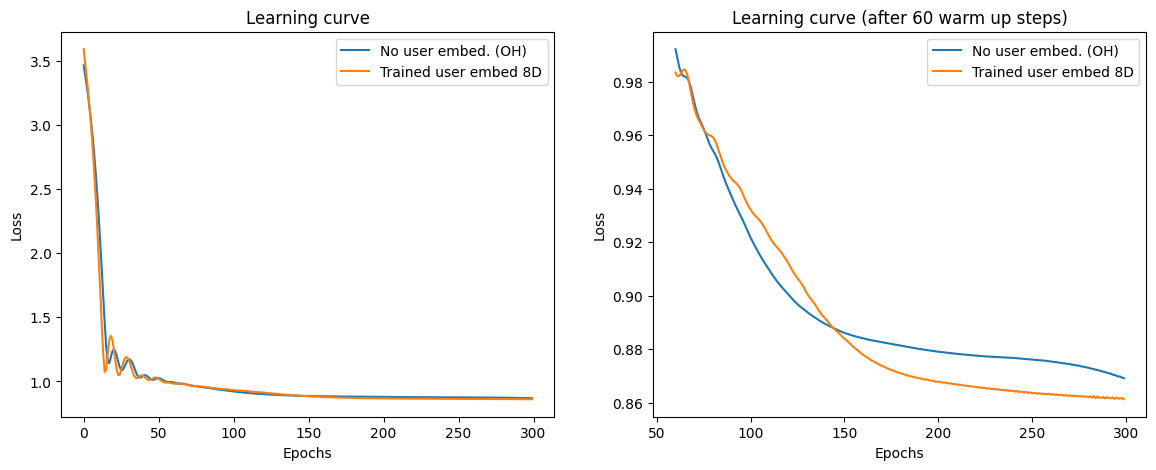

In [33]:
SKIP_WARM_UP_STEPS = 60

maps = ['No user embed. (OH)', 'Trained user embed 8D']

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
for i, label in enumerate(maps):
    ax0.plot(comp_val_losses[i], label=label)
    ax1.plot(range(SKIP_WARM_UP_STEPS, len(comp_val_losses[0])), comp_val_losses[i][SKIP_WARM_UP_STEPS:], label=label)

ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()